# 1. Понимание поставленной задачи

## 1.1 Цель
Предсказать качество вина

## 1.2 Описание
Винодельческая отрасль сейчас активно развивается, спрос на вино увеличивается год от года. Цена вина зависит от довольно абстрактной концепции оценки вина дегустаторами, мнение которых может иметь высокую степень изменчивости. Другим ключевым фактором в сертификации вина и оценке качества являются физико-химические тесты, которые проводятся на лабораторной основе и учитывают такие факторы, как кислотность, уровень pH, наличие сахара и другие химические свойства. 

Доступен датасет, содержащий данные о сортах красного и  белого вина. Все вина производятся в определенном районе Португалии. Собираются данные по 12 различным свойствам вин, одним из которых является качество, основанное на сенсорных данных, а остальные - химическими свойствами вин, включая плотность, кислотность, содержание алкоголя и т. Д. Каждый сорт вина дегустируется тремя независимыми дегустаторами, и окончательным назначаемым рангом является средний ранг, данный дегустаторами.

Предлагается применить инструменты машинного обучения для предсказания качественной оценки вина на основании его физико-химических свойств.

[Описание от Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

# 2. Обзор данных

## 2.1 Загрузка библиотек

In [13]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [11]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [66]:
data = pd.read_csv('winequalityN.csv')

## 2.4 Статистика и визуализации

In [25]:
data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Описание переменных

Входные переменные (на основе физико-химических свойств):
 - type: белое вино (white) или красное вино (red)
 - fixed acidity: фиксированная кислотность
 - volatile acidity: летучая кислотность
 - citric acid: лимонная кислота
 - residual sugar: остаточный сахар
 - chlorides: хлориды
 - free sulfur dioxide: свободный диоксид серы
 - total sulfur dioxide: общий диоксид серы
 - density: плотность
 - pH: водородный показатель
 - sulphates: сульфаты
 - alcohol: спиртосодердание

Выходная переменная (на основе сенсорных данных):
 - quality: качество (оценка от 0 до 10)

[Больше информации на сайте Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

### 2.4.1 Ключевая информация о переменных

In [8]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

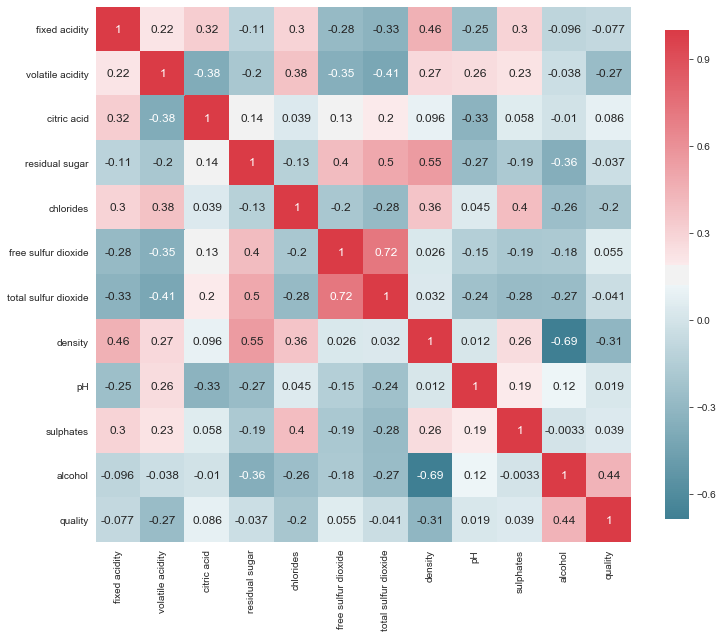

In [14]:
plot_correlation_map(data)

### 2.4.3 Cтруктура выходной переменной

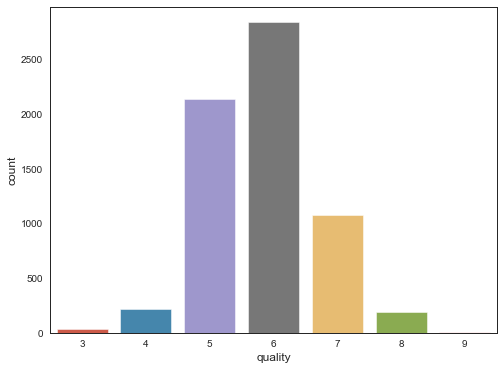

In [69]:
sns.countplot(x='quality', data=data)

### 2.4.4 Подробное рассмотрение взаимосвязи между свойствами и качеством
Начнем с рассмотрения взаимосвязи между остаточным сахаром и качеством. Качество вина будем считать хорошим, если дана оценка больше или равная 7.

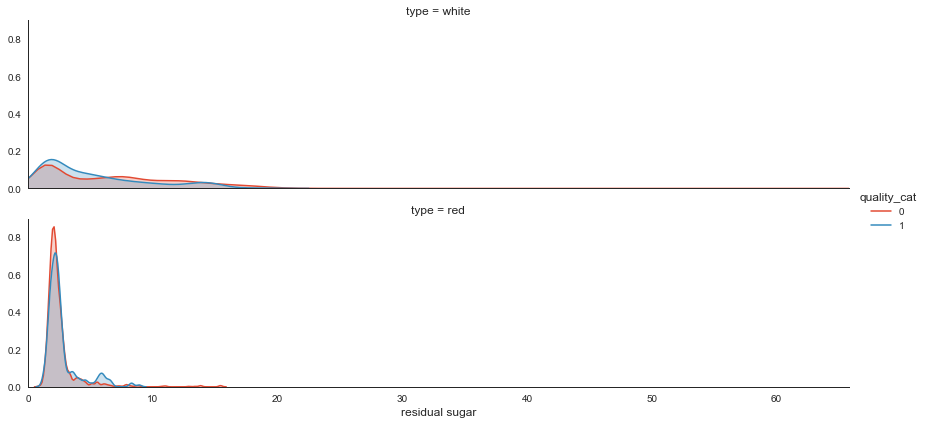

In [72]:
data['quality_cat'] = data ['quality']
data['quality_cat'] = data['quality_cat'].replace(1, 0)
data['quality_cat'] = data['quality_cat'].replace(2, 0)
data['quality_cat'] = data['quality_cat'].replace(3, 0)
data['quality_cat'] = data['quality_cat'].replace(4, 0)
data['quality_cat'] = data['quality_cat'].replace(5, 0)
data['quality_cat'] = data['quality_cat'].replace(6, 0)
data['quality_cat'] = data['quality_cat'].replace(7, 1)
data['quality_cat'] = data['quality_cat'].replace(8, 1)
data['quality_cat'] = data['quality_cat'].replace(9, 1)
data['quality_cat'] = data['quality_cat'].replace(10, 1)
plot_distribution( data , var = 'residual sugar' , target = 'quality_cat' , row = 'type' )

Рассмотрим графики выше. Различия в оценке для разных значений - это то, что будет использоваться для разделения целевой переменной в модели. Если бы две линии были примерно одинаковыми, то это не было бы хорошей переменной для модели.

Теперь посмотрим, как спиртосодержение влияет на качество вина.

[Text(0, 0.5, 'Alcohol Percent'),
 Text(0.5, 0, 'Wine Quality'),
 Text(0.5, 1.0, 'Alcohol percent in different wine quality types')]

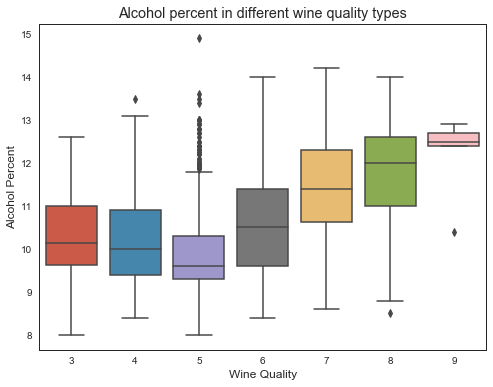

In [70]:
bx = sns.boxplot(x="quality", y='alcohol', data = data)
bx.set(xlabel='Wine Quality', ylabel='Alcohol Percent', title='Alcohol percent in different wine quality types')

Рассмотри взаимосвязь между содержанием сульфатов и качеством вина.

[Text(0, 0.5, 'Sulphates'),
 Text(0.5, 0, 'Wine Ratings'),
 Text(0.5, 1.0, 'Sulphates in different types of Wine ratings')]

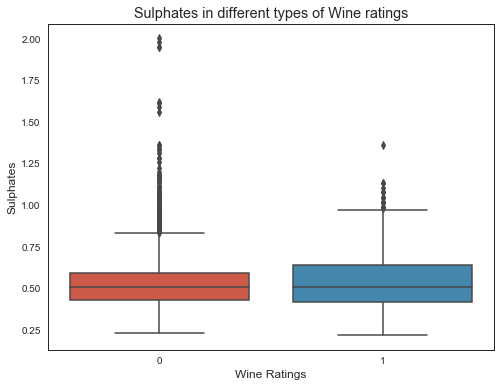

In [73]:
bx = sns.boxplot(x="quality_cat", y='sulphates', data = data)
bx.set(xlabel='Wine Ratings', ylabel='Sulphates', title='Sulphates in different types of Wine ratings')

# 3. Data Preparation





## 3.1 Заполнить пропущенные значения в переменных
В нашем датасете пропущенные значения имеются в следующих столбцах: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, pH, sulphates.

Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе. Столбцы без пропущенных значений оставим без изменений.

In [46]:
# Create dataset
imputed = pd.DataFrame()
normal = pd.DataFrame()      

# Fill missing values with the average 
normal[ 'type' ] = data['type']
normal[ 'alcohol' ] = data['alcohol']
normal[ 'free sulfur dioxide' ] = data['free sulfur dioxide']
normal[ 'total sulfur dioxide' ] = data['total sulfur dioxide']
normal[ 'density' ] = data['density']
normal[ 'quality' ] = data['quality_cat']
imputed[ 'fixed acidity' ] = data['fixed acidity'].fillna( data['fixed acidity'].mean())
imputed[ 'volatile acidity' ] = data['volatile acidity'].fillna( data['volatile acidity'].mean())
imputed[ 'citric acid' ] = data['citric acid'].fillna( data['citric acid'].mean())
imputed[ 'residual sugar' ] = data['residual sugar'].fillna( data['residual sugar'].mean())
imputed[ 'sulphates' ] = data['sulphates'].fillna( data['sulphates'].mean())
imputed[ 'chlorides' ] = data['chlorides'].fillna( data['chlorides'].mean())
imputed[ 'pH' ] = data['pH'].fillna( data['pH'].mean())
imputed

,fixed acidity,volatile acidity,citric acid,residual sugar,sulphates,chlorides,pH
0,7.0,0.270,0.36,20.7,0.450000,0.045,3.00
1,6.3,0.300,0.34,1.6,0.490000,0.049,3.30
2,8.1,0.280,0.40,6.9,0.440000,0.050,3.26
3,7.2,0.230,0.32,8.5,0.400000,0.058,3.19
4,7.2,0.230,0.32,8.5,0.400000,0.058,3.19
...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.580000,0.090,3.45
6493,5.9,0.550,0.10,2.2,0.531215,0.062,3.52
6494,6.3,0.510,0.13,2.3,0.750000,0.076,3.42
6495,5.9,0.645,0.12,2.0,0.710000,0.075,3.57


## 3.2 Категориальные переменные
В нашем датасете нет категоиальных входных переменных, если не считать тип вина. Разумно проводить независсимые исследования для красного и беого вина. Разделим наши данные на две части:

In [47]:
red = data[data['type'].str.contains("red")]
white = data[data['type'].str.contains("white")]

## 3.3 Сборка финальных датасетов для моделирования
### 3.3.1 Выбираем переменные

In [48]:
data_final = pd.concat( [ imputed , normal ] , axis=1 )
red_final = data_final[data_final['type'].str.contains("red")]
white_final = data_final[data_final['type'].str.contains("white")]
red_final = red_final.drop (columns = ['type'])
white_final = white_final.drop (columns = ['type'])
white_final.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,sulphates,chlorides,pH,alcohol,free sulfur dioxide,total sulfur dioxide,density,quality
0,7.0,0.27,0.36,20.7,0.45,0.045,3.00,8.8,45.0,170.0,1.0010,0
1,6.3,0.30,0.34,1.6,0.49,0.049,3.30,9.5,14.0,132.0,0.9940,0
2,8.1,0.28,0.40,6.9,0.44,0.050,3.26,10.1,30.0,97.0,0.9951,0
3,7.2,0.23,0.32,8.5,0.40,0.058,3.19,9.9,47.0,186.0,0.9956,0
4,7.2,0.23,0.32,8.5,0.40,0.058,3.19,9.9,47.0,186.0,0.9956,0


## 3.3.2 Создание датасетов

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(white_final.drop (columns = ['quality']),white_final.quality, test_size=0.33, random_state=42)

## 3.3.3 Важность признаков

1.0


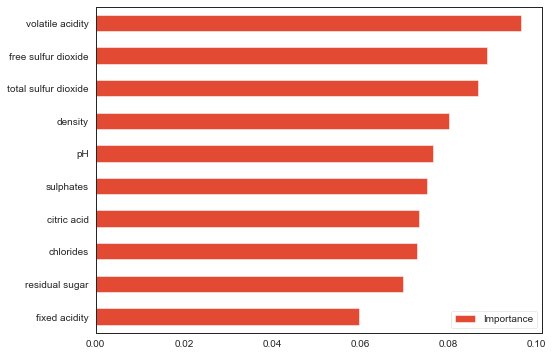

In [60]:
plot_variable_importance(X_train , y_train)

# 4. Моделирование


## 4.1 Выбор модели


In [ ]:
model = LogisticRegression()

## 4.1 Обучение модели

In [59]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# 5. Оценка модели

In [58]:
print (model.score( X_train , y_train ) , model.score( X_test , y_test ))

0.8037183785431271 0.7940630797773655


# 6. Развёртывание

In [ ]:
test_Y = model.predict( X_test )
test = pd.DataFrame('quality': test_Y )
test.shape
test.head()
test.to_csv( 'wine_pred.csv' , index = False )